In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.io import read_image, ImageReadMode, write_video
import torchvision.transforms as T
from random import randint
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output

import numpy as np
import pylab as pl
from importlib import reload  

from scripts import *
from CA_model import *
from virus_CA import *

In [2]:
N_CHANNELS = 16        # Number of CA state channels
TARGET_PADDING = 16    # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 4
N_ITERS = 45           # Iterations before applying the loss
POOL_SIZE = 512
CELL_FIRE_RATE = 0.5
VIRUS_PROPORTION = 0.1

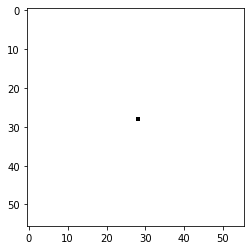

In [3]:
# Starting state
pool = SamplePool(POOL_SIZE, N_CHANNELS, IMAGE_SIZE)
imshow(pool[0][0])

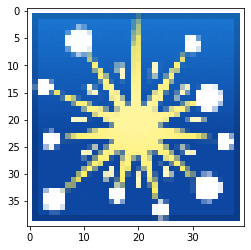

In [4]:
# Imports the target emoji
target = read_image("firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

In [5]:
target = target.cpu()
loss_fn(pad(target, TARGET_PADDING), 1)(pool.sample(16)[0])

(tensor(0.2883), tensor(0))

In [6]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target = target.to(device)

In [7]:
# loads a pretrained model
old_CA = CAModel().to(device)
old_CA.load("not_persistent.pt")

Successfully loaded model!


In [9]:
new_CA = CAModel().to(device)
new_CA.load("not_persistent.pt")

Successfully loaded model!


In [10]:
# Define the virus model
model = VirusCA(old_CA, new_CA)

In [119]:
# Train the model
torch.backends.cudnn.benchmark = True

for param in model.old_CA.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(model.new_CA.parameters())
criterion = loss_fn(pad(target, TARGET_PADDING), order=2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
losses = []
# torch.nn.utils.clip_grad_norm_(model.new_CA.parameters(), 1.)

model.train_CA(optimizer, criterion, pool, 200, scheduler=scheduler)

tensor(0.4159, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


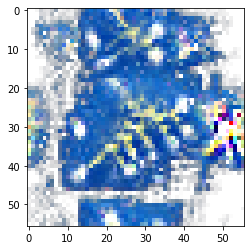

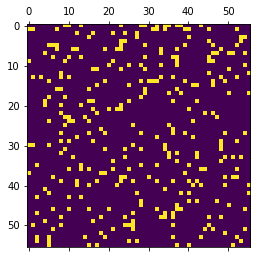

In [149]:
imshow(model.evolve(torch.unsqueeze(pool[0][0], 0).cuda(), 150)[0])
pl.matshow(model.new_cells.detach().cpu()[0,0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


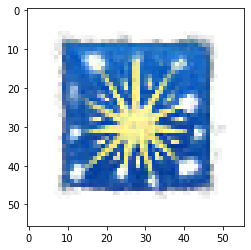

In [17]:
# Plots the learned CA
x, _ = pool.sample(1)
x = x.to(device)
x = model.evolve(x, N_ITERS)

imshow(x[0])

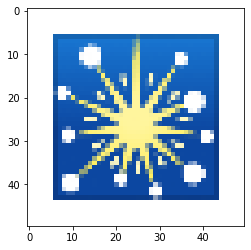

In [21]:
# Plots the true emoji
imshow(TraintoFloat(pad(target, 10, -1)))